---
### Closed-Form Solution with Michaelis-Menten Kinetics

Solve for lambda and Y with built-in Python library

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a1, a2 = 23.8, 1.4
k1, k2 = 0.01, 0.1
# k2 = 0.003
N = 200
b_min, b_max = 5e-4, 0.1
b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)
#b_vals = np.linspace(b_min, b_max, N+1)

### Softmax transformation

In [6]:
# Softmax transformation from u1, u2 -> theta1, theta2, theta3 (LogSumExp)
from scipy.special import logsumexp
def softmax_partition(u):
    u1, u2 = u
    logZ = logsumexp([u1, 0.0, u2])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(-logZ)
    theta3 = np.exp(u2 - logZ)
    return theta1, theta2, theta3

# System
def BioSystemMM3(theta, b_val):
    term_Y1 = (a1 * theta[1]) / (b_val * theta[0]) + k1 - 1
    Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
    term_Y2 = (a2 * theta[2]) / (b_val * theta[0]) + k2 - (1 - Y1)
    Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
    Y3 = (a2 * theta[2] / b_val) * (Y2 / (k2 + Y2))
    Y4 = (a2 * theta[1] * theta[2] / (b_val * theta[0])) * (Y2 / (k2 + Y2))
    Y5 = (a2 * theta[2]**2 / (b_val * theta[0])) * (Y2 / (k2 + Y2))
    lambda_val = b_val * Y3
    r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))
    r_avg = 1 / r_denom if r_denom != 0 else np.nan
    return np.array([b_val, theta[0], theta[1], theta[2], Y1, Y2, Y3, Y4, Y5, lambda_val, r_avg])

def objective_softmax(u, b_val): return -BioSystemMM3(softmax_partition(u), b_val)[9]   # objective function

# Optimization
def optimize_for_b_softmax(b_val, tol=1e-7, gtol=1e-8, maxiter=1000):
    result = minimize(
        lambda u: objective_softmax(u, b_val),
        x0=[0.0, 0.0],
        method='BFGS',
        tol=tol,                       # global tolerance
        options={
            'gtol': gtol,              # gradient tolerance
            'maxiter': maxiter,        # maximum iterations
            'disp': False               # display output: True
        }
    )
    if result.success: return BioSystemMM3(softmax_partition(result.x), b_val)

# Replacing BioSystemMM3(theta1, theta2. theta3, b_val) with BioSystemMM3(array, b_val) increased
# performance by more than threefold! (2s -> 0.6 s) 20250924

# Parallel execution
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = np.array([r for r in results if r is not None])
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

(b_arr, theta1_arr, theta2_arr, theta3_arr, 
 Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr, 
 lambda_arr, r_avg_arr) = results.T   # The "Pythonic" way using tuple unpacking!

Optimization completed in 0.70 seconds.


### Line fitting

In [1]:
from scipy.stats import linregress
# Perform linear regression
def linear_fit(x, y):
  slope, intercept, r_value, p_value, std_err = linregress(x, y)
  x_fit = np.linspace(min(x), max(x), 201)
  y_fit = slope * x_fit + intercept
  r_squared = r_value**2
  return [x_fit, y_fit, r_squared, slope, intercept]

# lambda vs. b (linear)
b_lambda_fit = linear_fit(b_arr, lambda_arr)
Y3_lambda_fit = linear_fit(Y3_arr, lambda_arr)
Y4_lambda_fit = linear_fit(Y4_arr, lambda_arr)
Y5_lambda_fit = linear_fit(Y5_arr, lambda_arr)

NameError: name 'b_arr' is not defined

### Plot the result

,Nutrient level,Growth rate,Y1,Y2,Y3,Y4,Y5,Sum_Y,Approx. Sum_Y
0,0.000500,0.000493,0.000459,0.005930,0.986883,0.000472,0.006256,1.0,None
1,0.000513,0.000507,0.000461,0.006016,0.986704,0.000483,0.006336,1.0,None
2,0.000527,0.000520,0.000472,0.006100,0.986522,0.000484,0.006421,1.0,None
3,0.000542,0.000534,0.000476,0.006182,0.986338,0.000494,0.006510,1.0,None
4,0.000556,0.000548,0.000480,0.006254,0.986152,0.000503,0.006611,1.0,None
...,...,...,...,...,...,...,...,...,...
193,0.089898,0.071986,0.005878,0.073408,0.800758,0.008123,0.111834,1.0,None
194,0.092323,0.073671,0.005953,0.074306,0.797963,0.008246,0.113532,1.0,None
195,0.094814,0.075390,0.006029,0.075214,0.795132,0.008371,0.115254,1.0,None
196,0.097373,0.077145,0.006106,0.076132,0.792266,0.008497,0.116999,1.0,None


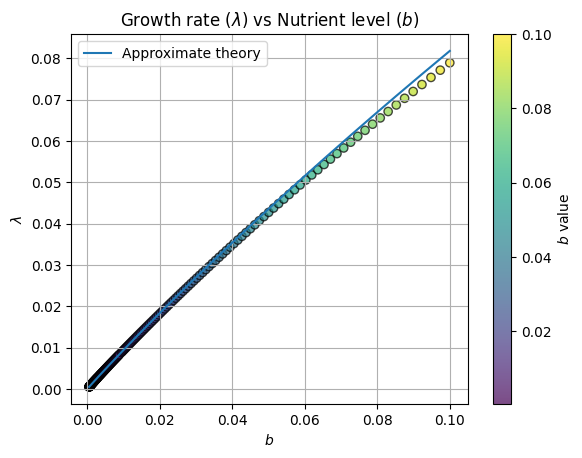

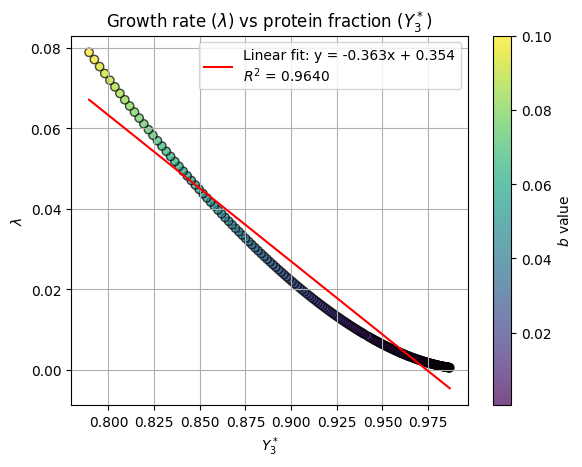

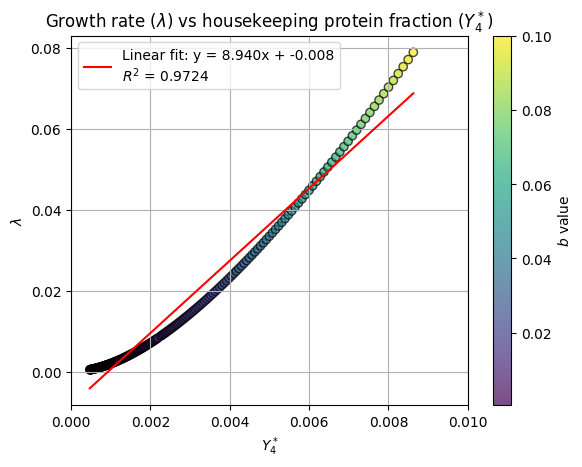

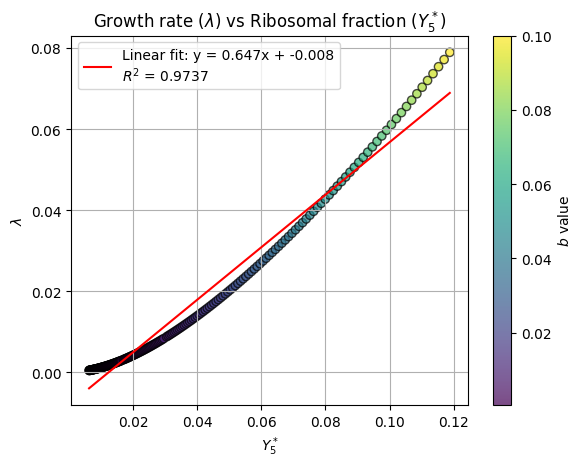

C:\Users\huang\AppData\Local\Temp\ipykernel_57180\996121618.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


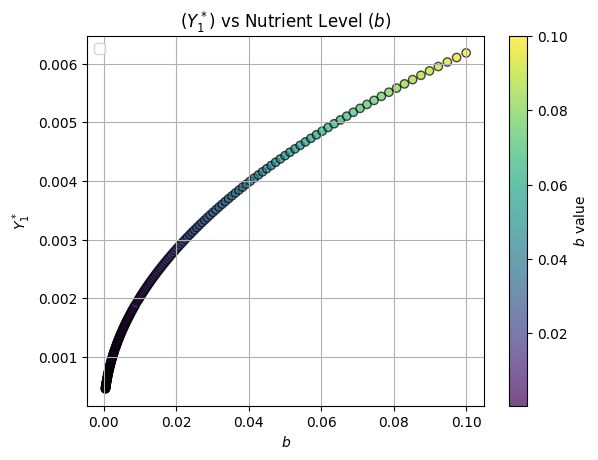

C:\Users\huang\AppData\Local\Temp\ipykernel_57180\996121618.py:81: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


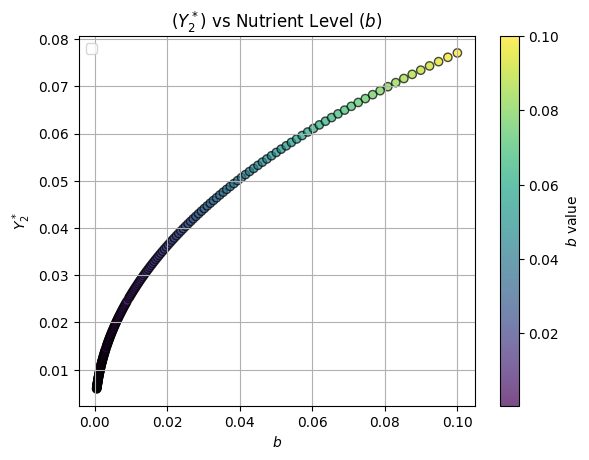

C:\Users\huang\AppData\Local\Temp\ipykernel_57180\996121618.py:91: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


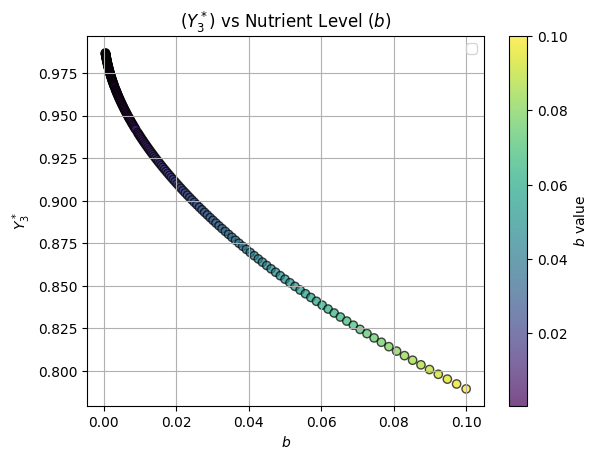

C:\Users\huang\AppData\Local\Temp\ipykernel_57180\996121618.py:101: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


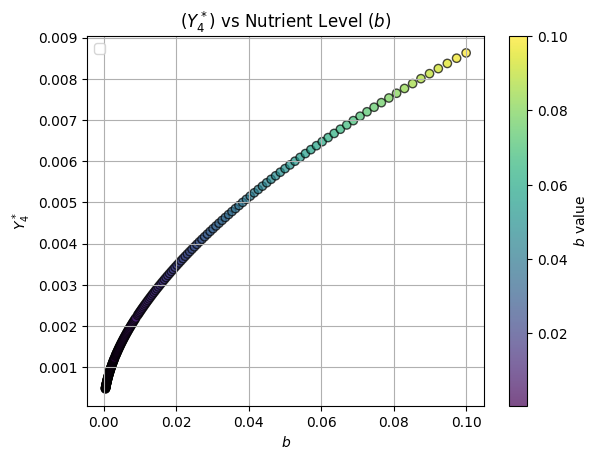

C:\Users\huang\AppData\Local\Temp\ipykernel_57180\996121618.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


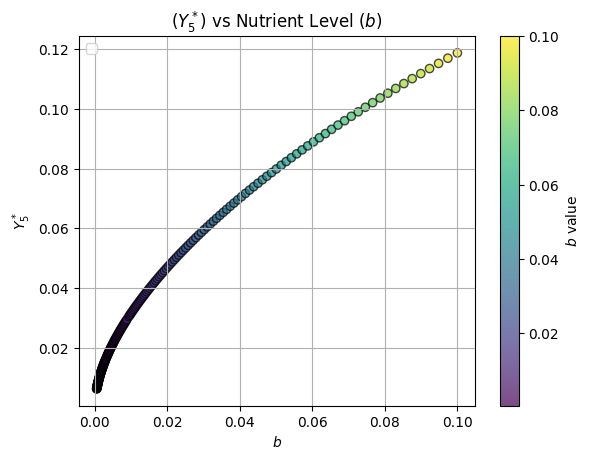

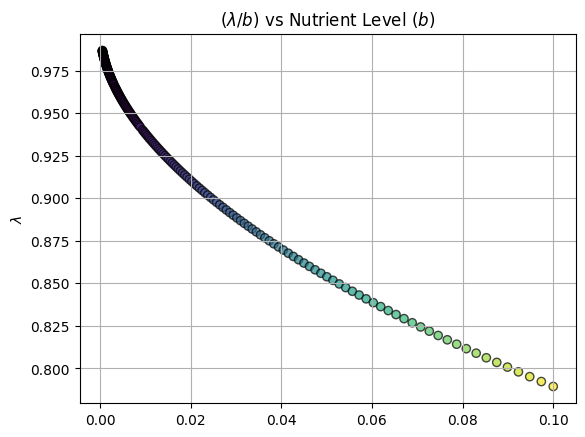

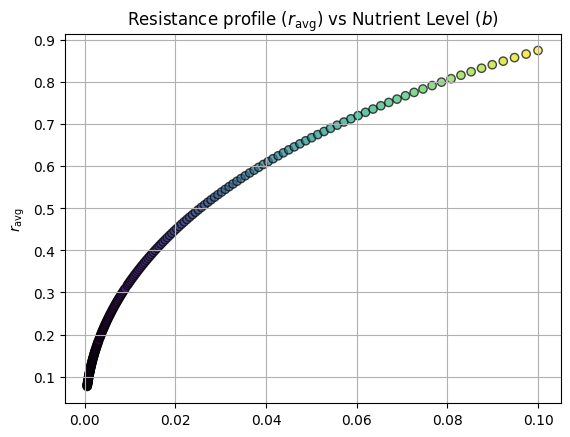

In [ ]:
# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Y1": Y1_arr,
    "Y2": Y2_arr,
    "Y3": Y3_arr,
    "Y4": Y4_arr,
    "Y5": Y5_arr,
    "Sum_Y": Y1_arr + Y2_arr + Y3_arr + Y4_arr + Y5_arr, 
    "Approx. Sum_Y": None
})
display(df)

# Growth rate to nutrient level (b)
lambda_approx_arr = b_arr - (np.sqrt(k1/a1) + np.sqrt(k2/a2))*b_arr**(3/2)
# lambda_approx_arr = b_arr - 2*(np.sqrt(k1/a1) + np.sqrt(k2/a2))*b_arr**(3/2)

plt.figure()
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(b_arr, lambda_approx_arr, '-', label='Approximate theory')
plt.xlabel(r'$b$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend()
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y3)
plt.figure()
scatter = plt.scatter(Y3_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y3_lambda_fit[0], Y3_lambda_fit[1], '-', label=f'Linear fit: y = {Y3_lambda_fit[3]:.3f}x + {Y3_lambda_fit[4]:.3f}\n$R^2$ = {Y3_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_3^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_3^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein fraction (Y4) -> this should be constant
plt.figure()
scatter = plt.scatter(Y4_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y4_lambda_fit[0], Y4_lambda_fit[1], '-', label=f'Linear fit: y = {Y4_lambda_fit[3]:.3f}x + {Y4_lambda_fit[4]:.3f}\n$R^2$ = {Y4_lambda_fit[2]:.4f}', color='red') # line of best fit
plt.xlabel(r'$Y_4^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs housekeeping protein fraction ($Y_4^*$)')
plt.grid(True)
plt.xlim(0, 0.01)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y5)
plt.figure()
scatter = plt.scatter(Y5_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(Y5_lambda_fit[0], Y5_lambda_fit[1], '-', 
label=f'Linear fit: y = {Y5_lambda_fit[3]:.3f}x + {Y5_lambda_fit[4]:.3f}\n$R^2$ = {Y5_lambda_fit[2]:.4f}', color='red')
plt.xlabel(r'$Y_5^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_5^*$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y1) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y1_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_1^*$')
plt.title(r'($Y_1^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y2) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y2_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_2^*$')
plt.title(r'($Y_2^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y3) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y3_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_3^*$')
plt.title(r'($Y_3^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y4) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y4_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_4^*$')
plt.title(r'($Y_4^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()

# (Y5) vs b
plt.figure()
scatter = plt.scatter(b_arr, Y5_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$b$'); plt.ylabel(r'$Y_5^*$')
plt.title(r'($Y_5^*$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.legend()
plt.show()


# Yield per unit input
plt.figure()
scatter = plt.scatter(b_arr, lambda_arr / b_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.ylabel(r'$\lambda$')
plt.title(r'($\lambda / b$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.show()

# Efficiency and Tradeoffs
plt.figure()
scatter = plt.scatter(b_arr, r_avg_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.ylabel(r'$r_\text{avg}$'); plt.title(r'Resistance profile ($r_\text{avg}$) vs Nutrient Level ($b$)')
plt.grid(True)
plt.show()

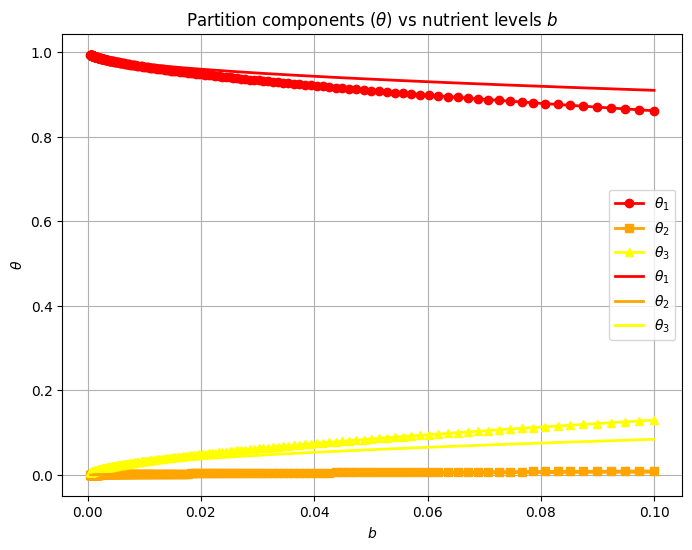

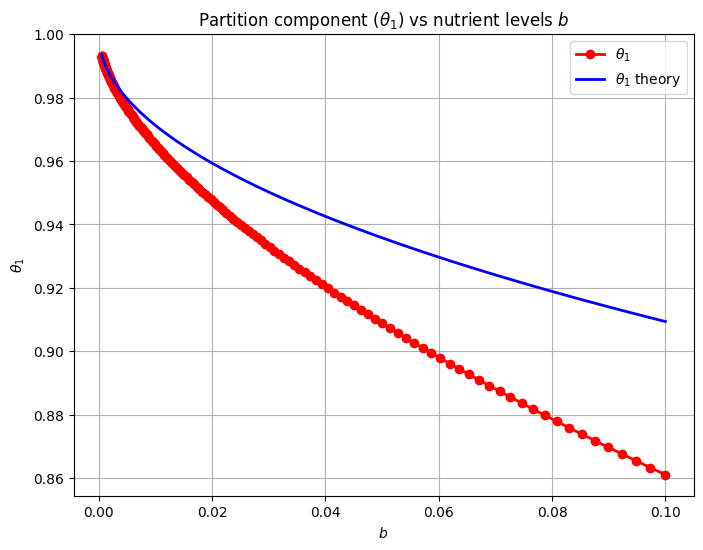

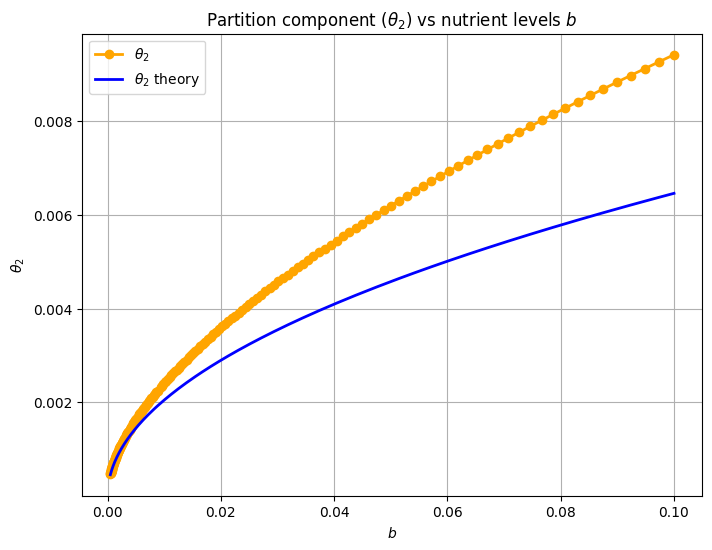

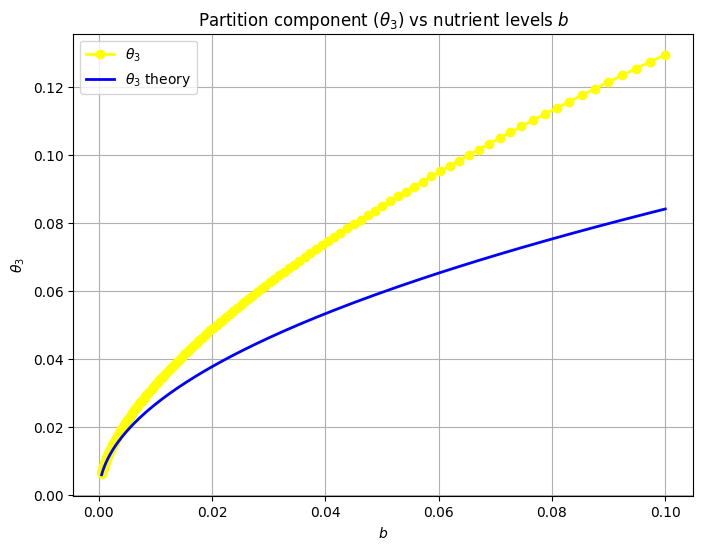

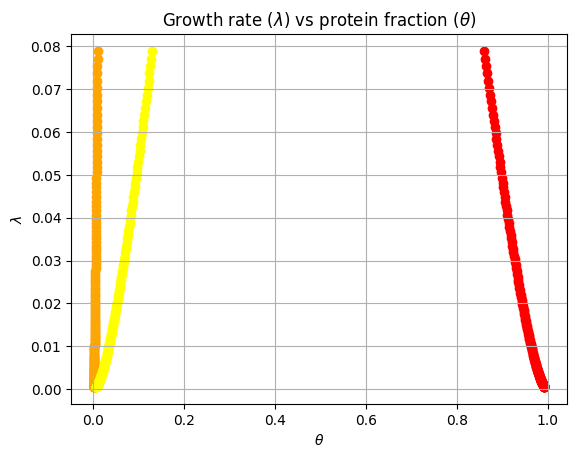

,Nutrient level,Growth rate,theta1,theta2,theta3,Sum_theta,Approx. Sum_theta
0,0.000500,0.000493,0.993228,0.000475,0.006296,1.0,1.0
1,0.000513,0.000507,0.993137,0.000486,0.006377,1.0,1.0
2,0.000527,0.000520,0.993049,0.000488,0.006464,1.0,1.0
3,0.000542,0.000534,0.992949,0.000497,0.006553,1.0,1.0
4,0.000556,0.000548,0.992838,0.000506,0.006656,1.0,1.0
...,...,...,...,...,...,...,...
193,0.089898,0.071986,0.869714,0.008822,0.121464,1.0,1.0
194,0.092323,0.073671,0.867595,0.008965,0.123439,1.0,1.0
195,0.094814,0.075390,0.865444,0.009111,0.125445,1.0,1.0
196,0.097373,0.077145,0.863259,0.009259,0.127482,1.0,1.0


In [111]:
# Approximate Theory
A = np.sqrt(k1/a1)+np.sqrt(k2/a2)
B = k1/a1 + k2/a2
C = a1/k1 + a2/k2
D = np.sqrt((k1*k2) / (a1*a2))
E = 1/a1 + 1/a2

# theta1_approx_arr = 1 - A * np.sqrt(b_arr) + (A**2-B-2*D)*b_arr - A*((3/2)*A**2-2*B-4*D)*b_arr**(3/2)
# theta2_approx_arr = np.sqrt(k1/a1)*( np.sqrt(b_arr) - (A**2-B-2*D)/A*b_arr + ((3/2)*A**2-2*B-4*D)*b_arr**(3/2) )
# theta3_approx_arr = np.sqrt(k2/a2)*( np.sqrt(b_arr) - (A**2-B-2*D)/A*b_arr + ((3/2)*A**2-2*B-4*D)*b_arr**(3/2) )

theta1_approx_arr = 1 - A*np.sqrt(b_arr) - (A**2-B-2*D)*b_arr - A*((3/2)*A**2-2*B-4*D)*b_arr**(3/2)
theta2_approx_arr = np.sqrt(k1/a1)*( np.sqrt(b_arr) + (A**2-B-2*D)/A*b_arr + ((3/2)*A**2-2*B-4*D)*b_arr**(3/2) )
theta3_approx_arr = np.sqrt(k2/a2)*( np.sqrt(b_arr) + (A**2-B-2*D)/A*b_arr + ((3/2)*A**2-2*B-4*D)*b_arr**(3/2) )

# Partition components to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='s', color='orange')
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='^', color='yellow')
plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$', linestyle='-', color='red')
plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$', linestyle='-', color='orange')
plt.plot(b_arr, theta3_approx_arr, lw=2, label=r'$\theta_3$', linestyle='-', color='yellow')
plt.xlabel(r'$b$')
plt.ylabel(r'$\theta$')
plt.title(r'Partition components ($\theta$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta1 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta1_arr, lw=2, label=r'$\theta_1$', marker='o', color='red')
plt.plot(b_arr, theta1_approx_arr, lw=2, label=r'$\theta_1$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_1$')
plt.title(r'Partition component ($\theta_1$) vs nutrient levels $b$')
plt.grid(True)
plt.legend()
plt.show()

# Partition component theta2 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta2_arr, lw=2, label=r'$\theta_2$', marker='o', color='orange')
plt.plot(b_arr, theta2_approx_arr, lw=2, label=r'$\theta_2$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_2$')
plt.title(r'Partition component ($\theta_2$) vs nutrient levels $b$')
plt.grid(True)
# plt.ylim(0.0, 0.01)
plt.legend()
plt.show()

# Partition component theta3 to nutrient levels b
plt.figure(figsize=(8,6))
plt.plot(b_arr, theta3_arr, lw=2, label=r'$\theta_3$', marker='o', color='yellow')
plt.plot(b_arr, theta3_approx_arr, lw=2, label=r'$\theta_3$ theory', color='blue')
plt.xlabel(r'$b$'); plt.ylabel(r'$\theta_3$')
plt.title(r'Partition component ($\theta_3$) vs nutrient levels $b$')
plt.grid(True)
# plt.ylim(0.0, 0.01)
plt.legend()
plt.show()

# Growth rate to protein partition \theta
plt.figure()
plt.scatter(theta1_arr, lambda_arr, label=r'$\theta_1$', c='red')
plt.scatter(theta2_arr, lambda_arr, label=r'$\theta_2$', c='orange')
plt.scatter(theta3_arr, lambda_arr, label=r'$\theta_3$', c='yellow')
plt.xlabel(r'$\theta$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($\theta$)')
plt.grid(True)
plt.show()

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "theta1": theta1_arr,
    "theta2": theta2_arr,
    "theta3": theta3_arr,
    "Sum_theta": theta1_arr + theta2_arr + theta3_arr, 
    "Approx. Sum_theta": theta1_approx_arr + theta2_approx_arr + theta3_approx_arr
})
display(df)

### Small and Large Molecules
The small molecules include metabolites and precursors. Large molecules include different types of proteins.

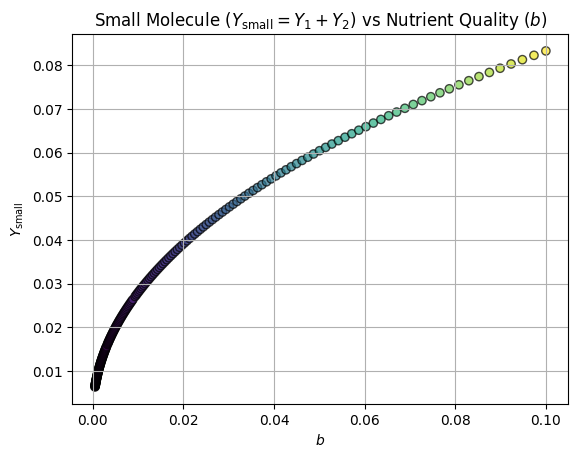

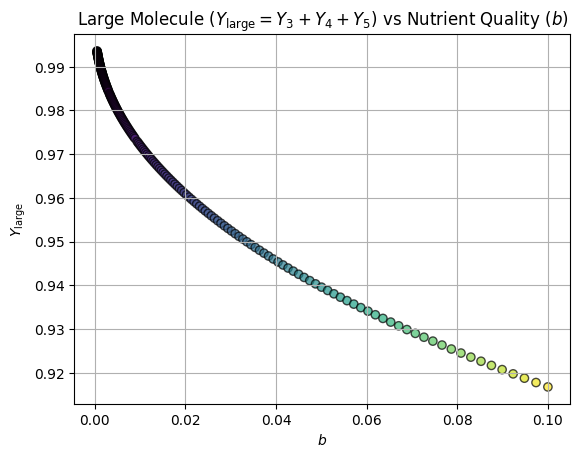

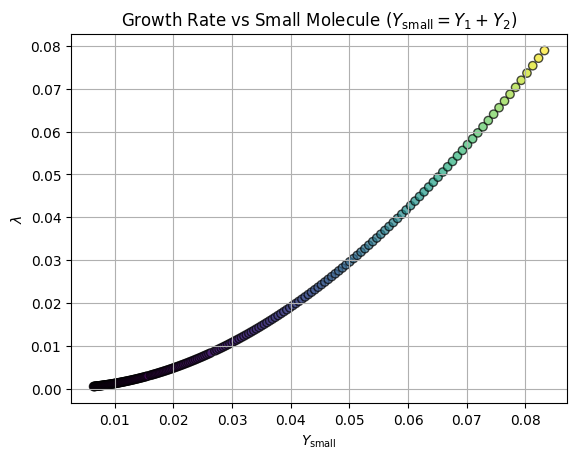

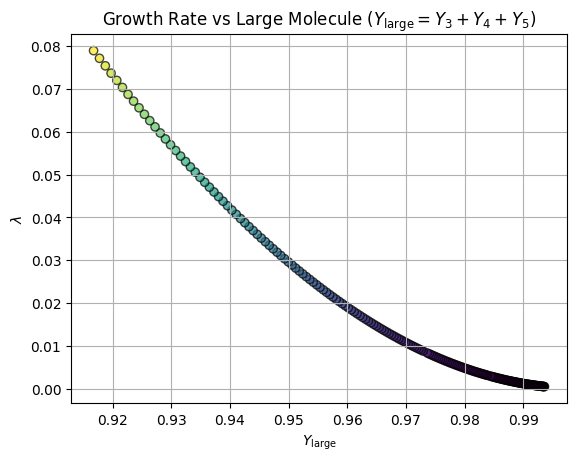

,Nutrient level,Growth rate,Small molecule fraction,Large molecule fraction
0,0.000500,0.000493,0.006389,0.993611
1,0.000513,0.000507,0.006477,0.993523
2,0.000527,0.000520,0.006572,0.993428
3,0.000542,0.000534,0.006658,0.993342
4,0.000556,0.000548,0.006734,0.993266
...,...,...,...,...
193,0.089898,0.071986,0.079286,0.920714
194,0.092323,0.073671,0.080259,0.919741
195,0.094814,0.075390,0.081243,0.918757
196,0.097373,0.077145,0.082238,0.917762


In [112]:
# Discuss different molecdule sizes
small_mol_arr = Y1_arr + Y2_arr
large_mol_arr = Y3_arr + Y4_arr + Y5_arr

# Small molecule (metabolites and a.a.'s) fraction (Y1 + Y2) to b
plt.figure()
scatter = plt.scatter(b_arr, small_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{small}$')
plt.title(r'Small Molecule ($Y_\text{small} = Y_1 + Y_2$) vs Nutrient Quality ($b$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(b_arr, large_mol_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_\text{large}$')
plt.title(r'Large Molecule ($Y_\text{large} = Y_3 + Y_4 + Y_5$) vs Nutrient Quality ($b$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(small_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$Y_\text{small}$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth Rate vs Small Molecule ($Y_\text{small} = Y_1 + Y_2$)')
plt.grid(True)
plt.show()

# Large molecule (proteins) fraction (Y3 + Y4 + Y5) to b
plt.figure()
scatter = plt.scatter(large_mol_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.xlabel(r'$Y_\text{large}$')
plt.ylabel(r'$\lambda$')
plt.title(r'Growth Rate vs Large Molecule ($Y_\text{large} = Y_3 + Y_4 + Y_5$)')
plt.grid(True)
plt.show()

# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Small molecule fraction": small_mol_arr,
    "Large molecule fraction": large_mol_arr,
})
display(df)

## Heat Map

<>:29: SyntaxWarning: invalid escape sequence '\l'
<>:29: SyntaxWarning: invalid escape sequence '\l'
C:\Users\huang\AppData\Local\Temp\ipykernel_57180\2682396739.py:29: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}')


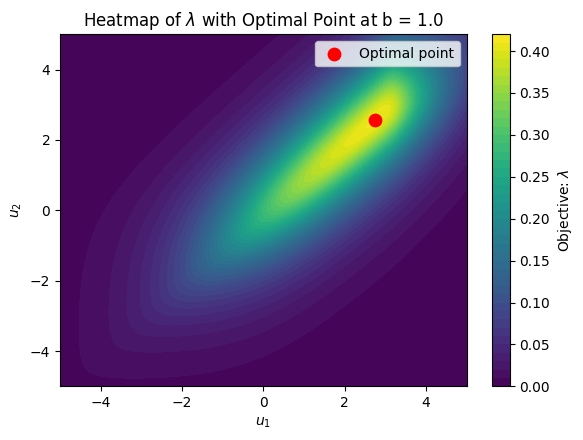

In [113]:
b_target = 1.0

opt_result = minimize(lambda u: objective_softmax(u, b_target), [0.0, 0.0], method='BFGS')

if opt_result.success:
    u1_opt, u2_opt = opt_result.x
    lambda_opt = -objective_softmax([u1_opt, u2_opt], b_target)
    theta1_opt, theta2_opt, theta3_opt = softmax_partition([u1_opt, u2_opt])
else:
    u1_opt = u2_opt = lambda_opt = theta1_opt = theta2_opt = theta3_opt = np.nan

# grid
u1_vals = np.linspace(-5, 5, 1000)
u2_vals = np.linspace(-5, 5, 1000)
U1, U2 = np.meshgrid(u1_vals, u2_vals)
Z = np.empty_like(U1)

# lambda value
for i in range(U1.shape[0]):
    for j in range(U1.shape[1]):
        Z[i, j] = - objective_softmax([U1[i, j], U2[i, j]], b_target)

# Plot
plt.figure(figsize=(6,4.5))
cp = plt.contourf(U1, U2, Z, levels=50, cmap='viridis')
plt.colorbar(cp, label=r'Objective: $\lambda$')
plt.scatter(u1_opt, u2_opt, color='red', marker='o', s=80, label='Optimal point')

plt.title(f'Heatmap of $\lambda$ with Optimal Point at b = {b_target}')
plt.xlabel('$u_1$')
plt.ylabel('$u_2$')
plt.legend()
plt.tight_layout()
plt.show()

## Code Dump

Using scipy.optimize import minimize

Finished in 0.36 seconds.


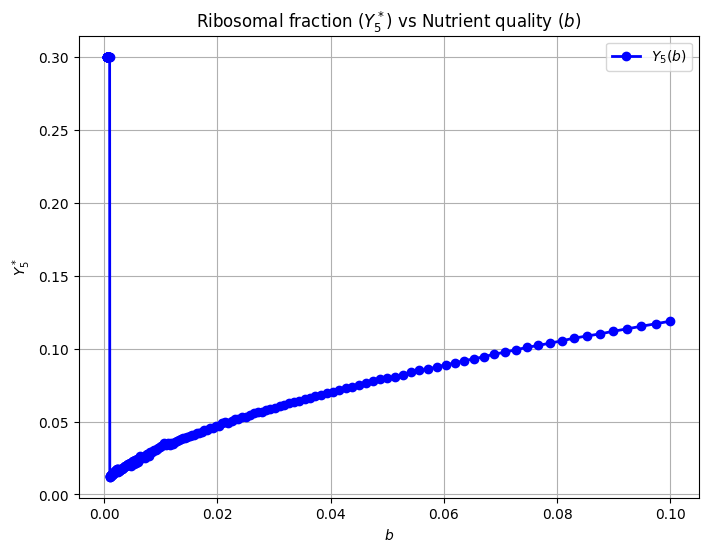

In [114]:
# Function to optimize
def optimize_for_b(b_val):
    def objective(t):
        t1, t3 = t
        if t1 + t3 >= 1 or t1 <= 0 or t3 <= 0:
            return np.inf
        t2 = 1 - t1 - t3
        try:
            term_Y1 = (a1 * t2) / (b_val * t1) + k1 - 1
            Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
            term_Y2 = (a2 * t3) / (b_val * t1) + k2 - (1 - Y1)
            Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
            if np.isnan(Y1) or np.isnan(Y2) or Y1 < 0 or Y2 < 0:
                return np.inf
            Y3 = (a2 * t3 / b_val) * (Y2 / (k2 + Y2))
            return -b_val * Y3
        except:
            return np.inf

    constraints = [{'type': 'ineq', 'fun': lambda t: 1 - t[0] - t[1]}]
    bounds = [(1e-6, 1.0), (1e-6, 1.0)]
    result = minimize(objective, [0.3, 0.3], method='SLSQP', bounds=bounds, constraints=constraints)

    if result.success:
        t1, t3 = result.x
        t2 = 1 - t1 - t3
        term_Y1 = (a1 * t2) / (b_val * t1) + k1 - 1
        Y1 = 0.5 * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
        term_Y2 = (a2 * t3) / (b_val * t1) + k2 - (1 - Y1)
        Y2 = 0.5 * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
        Y3 = (a2 * t3 / b_val) * (Y2 / (k2 + Y2))
        Y4 = (a2 * t2 * t3 / (b_val * t1)) * (Y2 / (k2 + Y2))
        Y5 = (a2 * t3**2 / (b_val * t1)) * (Y2 / (k2 + Y2))
        lambda_val = b_val * Y3
        r_denom = ((k1 + Y1) / (a1 * Y4)) + ((k2 + Y2) / (a2 * Y5))
        r_avg = 1 / r_denom if r_denom != 0 else np.nan
        return [b_val, [t1, t2, t3], [Y1, Y2, Y3, Y4, Y5], lambda_val, r_avg]
    return None

# Run in parallel
start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b)(b) for b in b_vals)
results = [res for res in results if res is not None]
print(f"Finished in {time.time() - start:.2f} seconds.")

# Save to arrays
b_arr = np.array([row[0] for row in results])
theta_arr = np.array([row[1] for row in results])
Y_arr = np.array([row[2] for row in results])
lambda_arr = np.array([row[3] for row in results])
r_avg_arr = np.array([row[4] for row in results])

theta1_arr, theta2_arr, theta3_arr = theta_arr.T
Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr = Y_arr.T

# Put in DataFrame
'''df = pd.DataFrame({
    "b": b_arr,
    "lambda": lambda_arr,
    "theta1": theta1_arr,
    "theta2": theta2_arr,
    "theta3": theta3_arr,
    "Y1": Y1_arr,
    "Y2": Y2_arr,
    "Y3": Y3_arr,
    "Y4": Y4_arr,
    "Y5": Y5_arr,
    "r_avg": r_avg_arr
})
display(df)'''

# Ribosomal fraction (Y5) to b
plt.figure(figsize=(8,6)) # set size of the graph (call before plt.plot)
plt.plot(b_arr, Y5_arr, lw=2, label=r'$Y_5(b)$', marker='o', color='blue')
plt.xlabel(r'$b$')
plt.ylabel(r'$Y_5^*$')
plt.title(r'Ribosomal fraction ($Y_5^*$) vs Nutrient quality ($b$)')
plt.grid(True)
plt.legend()
plt.show()